In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#source activate analysis
# %load /archives/data/tw/dbahr/read_stationid.py
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wrf import getvar,ALL_TIMES
import glob
from netCDF4 import Dataset
from datetime import datetime,timedelta
import matplotlib as mpl
import matplotlib.font_manager as fm
from scipy.stats import pearsonr
import sys
sys.path.insert(0,'/wrk/simon/scripts/python/functions/')
from usual_functions import istack, hidecode
from matlab_functions import ismember
from read_cwb import read_cwbmetst, read_cwbmetauto, read_cwbmet, get_cwbtime
from read_twepa import read_epastf, read_epast, get_epatime, get_epadata
fontpath='/usr/share/fonts/adobe-source-han-sans-tw/SourceHanSansTW-Normal.otf'
fontp=fm.FontProperties(family = u'Source Han Sans TW',fname=fontpath)
scrit='nearest'
#search radius in degree
srds=0.4
fout='png'
stx=120.2
sty=23.8
scnm='wrf'
plotts=1
plotsc=1

In [2]:
dpath='/archives/data/tw/dbahr/'
#url=r'http://e-service.cwb.gov.tw/wdps/obs/state.htm'
url=dpath+'state.htm'
stx0,sty0,stnm0,stnm0a=read_cwbmetst(url,dsource='dbahr')
fpattern='/archives/data/tw/dbahr/[0-9]*_auto_hr.txt'
df1,stnm1=read_cwbmetauto(fpattern,dsource='dbahr')
fpattern='/archives/data/tw/dbahr/[0-9]*_cwb_hr.txt'
df2,stnm2=read_cwbmet(fpattern,dsource='dbahr')
stx00,sty00,stnm00,stnm0a0=read_epastf('/archives/data/tw/erdb/airquality_stations.csv')
fpatterns='/archives/data/tw/epa/*/*xls'
df3,stnm3=read_epast(fpatterns)
#epa station serial number is not used in station data so station name is used to id the station here
stnm0=np.concatenate((stnm0,stnm0a0))
stnm0a=np.concatenate((stnm0a,stnm0a0))
stx0=np.concatenate((stx0,stx00))
sty0=np.concatenate((sty0,sty00))

In [11]:
tt=[];uv=[];psfc=[];tsk=[];rh=[];
#dname='/archives/simon/wrf/yulin3w0/WRFV3/'
dname='/archives/simon/wrf/yulin3wda0/WRFV3/'
for nf,filename in enumerate(glob.glob(dname+'2014*/wrfout_d03_2014-*')):
    #print('reading '+filename) 
    nc=Dataset(filename)
    tt=istack(tt,getvar(nc,"times",timeidx=ALL_TIMES).data+np.timedelta64(8,'h'))
    uv=istack(uv,getvar(nc,"uvmet10",timeidx=ALL_TIMES).data)
    psfc=istack(psfc,getvar(nc,"PSFC",timeidx=ALL_TIMES).data)
    tsk=istack(tsk,getvar(nc,"T2",timeidx=ALL_TIMES).data)
    rh=istack(rh,getvar(nc,"rh2",timeidx=ALL_TIMES).data)
    if nf==0:
        lon=getvar(nc,"lon",timeidx=ALL_TIMES).data
        lat=getvar(nc,"lat",timeidx=ALL_TIMES).data  
        if np.ndim(lon)==3:
            lon=lon[0,:,:]
            lat=lat[0,:,:]       
(d1,d3,d4)=psfc.shape
dx=lon[1,1]-lon[0,0]
dy=lat[1,1]-lat[0,0]

In [12]:
#sort wrfout
tind=np.argsort(tt.ravel()) 
tt=tt[tind].ravel()
uv=uv[tind,:,:,:]
psfc=psfc[tind,:,:]
tsk=tsk[tind,:,:]
rh=rh[tind,:,:]
tt2=np.array(list(map(lambda x: pd.Timestamp(x).to_pydatetime(), tt)))

In [5]:
def calc_errors():
    from __main__ import jj,sti    
    from __main__ import yy,yy1,tt1,tt2
    from __main__ import bias,rmse,r,p,stn,stna
    from __main__ import stnm0a
    ic,ia=ismember(tt2,tt1)
    ers=yy[ic]-yy1[ia]
    if sum(np.invert(np.isnan(ers))) >3:        
        xs=yy[ic];ys=yy1[ia]
        nind=np.invert(np.isnan(xs))&np.invert(np.isnan(ys))                            
        rii,pii=pearsonr(xs[nind],ys[nind])
        bias[jj-2].append(np.nanmean(ers));rmse[jj-2].append(np.nanmean(ers**2)**0.5)
        r[jj-2].append(rii);p[jj-2].append(pii)        
    else:
        bias[jj-2].append(np.nan);rmse[jj-2].append(np.nan)
        r[jj-2].append(np.nan);p[jj-2].append(np.nan)
    stn[jj-2].append(stnm0[sti]);stna[jj-2].append(stnm0a[sti])

In [6]:
def plt_ts(axi):    
    from __main__ import tt1,yy1,tt,yy,yy3,tt3    
    from __main__ import xmin,xmax,ymin,ymax,days5,days1,tfmt
    axi.plot(tt1,yy1,'-',color='b',markersize=1)
    axi.plot(tt3,yy3,'-',color='g',markersize=1)
    axi.plot(tt,yy,'-',color='r',markersize=1)
    axi.axis([xmin,xmax,ymin,ymax])
    axi.xaxis.set_major_locator(days5)
    axi.xaxis.set_minor_locator(days1)
    axi.xaxis.set_major_formatter(tfmt)

In [7]:
def get_model(cnm):
    if cnm=='WD01':
        from __main__ import uv,xi,yi
        yy=abs(uv[:,0,xi,yi]+uv[:,1,xi,yi]*1j)
        #ymin=0;ymax=10
        ymin=0;ymax=25
        txx=0.05;txy=0.95                
        vnm0='wind speed(m/s)'
        inc=5
    elif cnm=='RH01':
        from __main__ import rh,xi,yi
        yy=rh[:,xi,yi]
        ymin=50;ymax=100
        txx=0.4; txy=0.5
        vnm0='RH (%)'
        inc=10
    elif cnm=='TX01':
        from __main__ import tsk,xi,yi
        yy=tsk[:,xi,yi]-273.15
        ymin=22;ymax=37
        #ymin=10;ymax=25
        txx=0.05;txy=0.95
        vnm0='T ($^\circ$C)'
        inc=5
    elif cnm=='PS01':
        from __main__ import psfc,xi,yi
        yy=psfc[:,xi,yi]/100
        ymin=980;ymax=1020
        #ymin=1000;ymax=1040
        txx=0.05;txy=0.95
        vnm0='P (hPa)'
        inc=10
    return yy,ymin,ymax,txx,txy,vnm0,inc

In [10]:
ys3=ys2;ts3=ts2

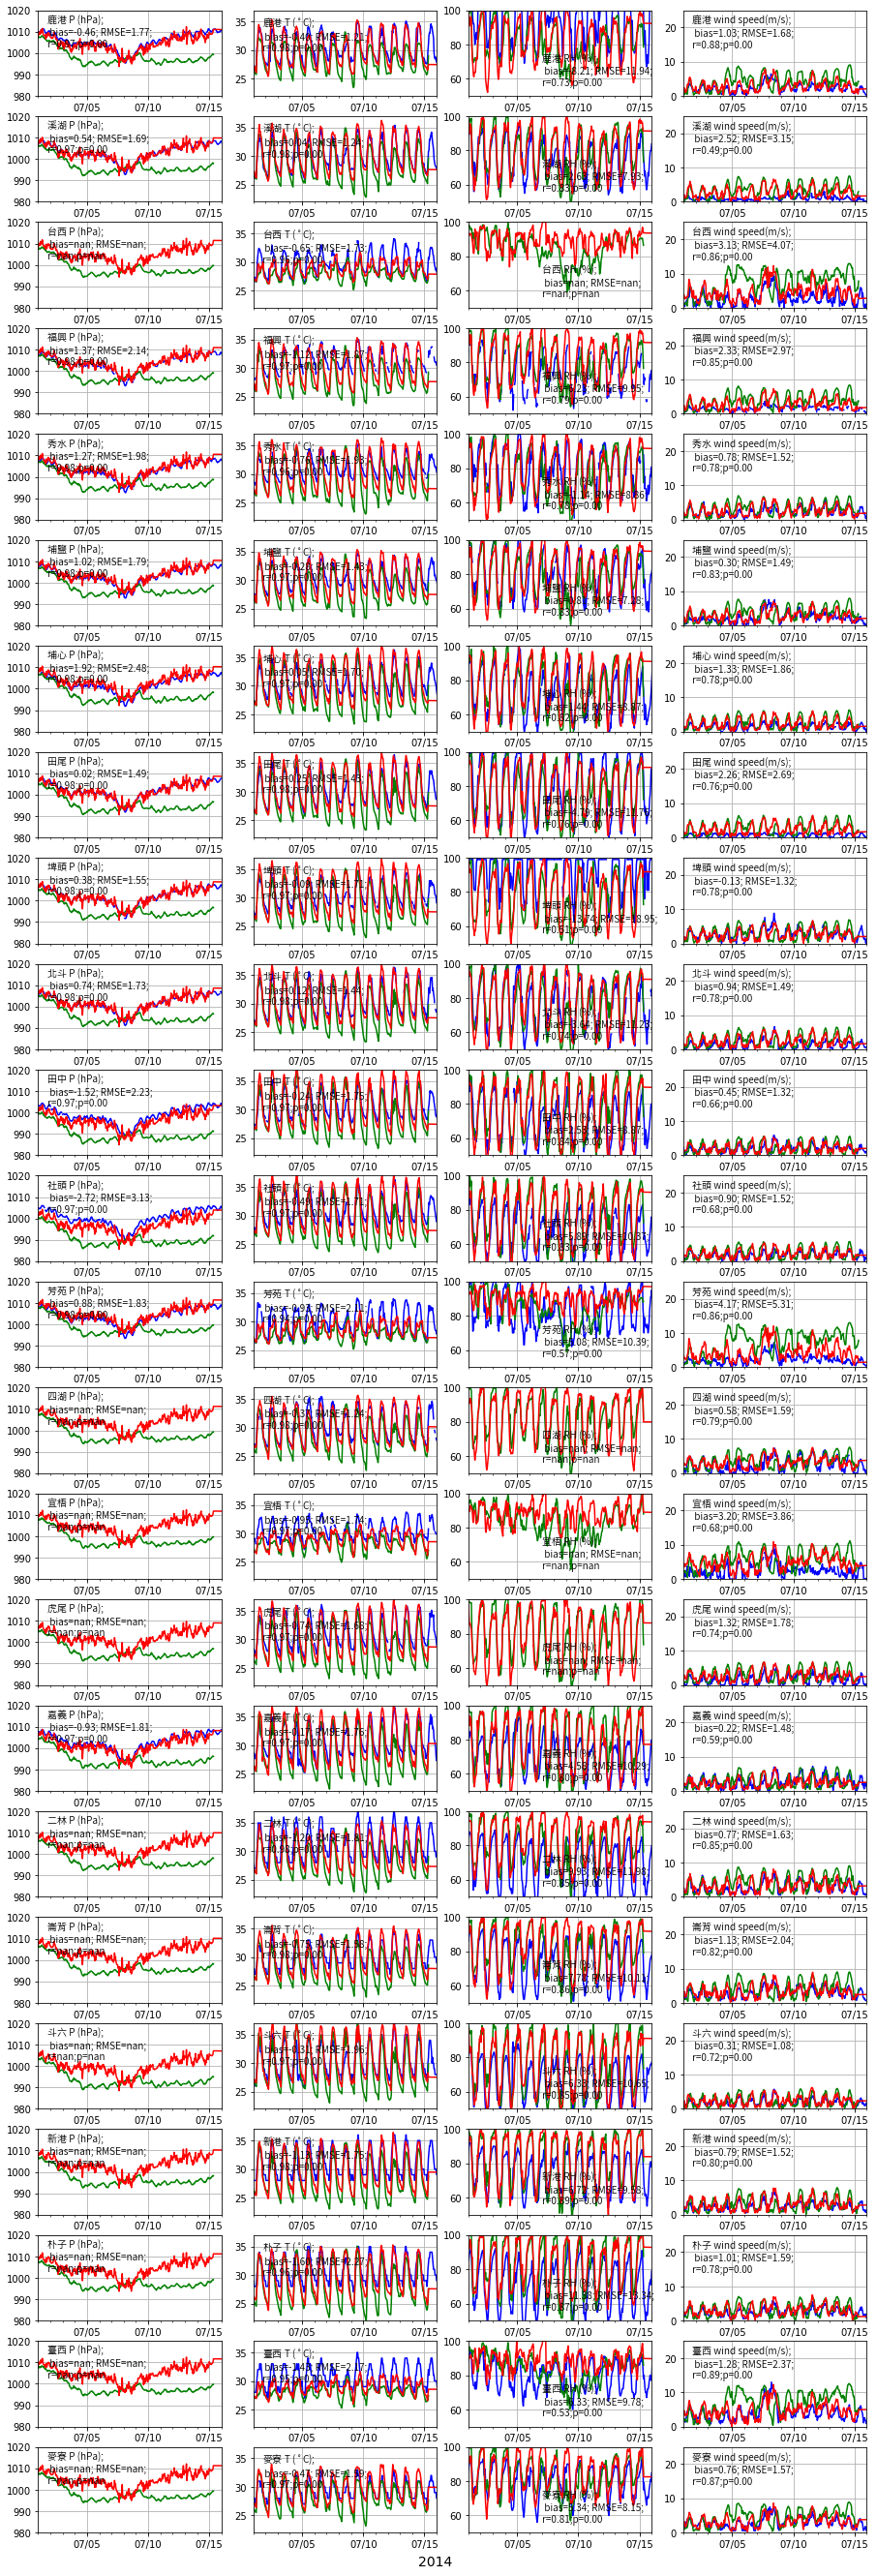

In [15]:
filename=''.join([scnm,'_all_cwb'])
xmin=min(tt2)
xmax=max(tt2)
nn=0
ng=0
bias=[[],[],[],[]];rmse=[[],[],[],[]];r=[[],[],[],[]];p=[[],[],[],[]];stn=[[],[],[],[]];stna=[[],[],[],[]]
ys1=[[],[],[],[]];ys2=[[],[],[],[]];ts1=[[],[],[],[]];ts2=[[],[],[],[]];xdists=[]
for nd,dfi in enumerate((df1,df2,df3)):    
    for ii,group in enumerate(dfi):
        if ii==0:
            if nd==1:
                cnm0=cnm
                cnm1=group[1].columns
                ic,ia=ismember(cnm0,cnm1)
                ia=ia[np.invert(np.isnan(ia))].astype(int)
                cnm=cnm1[ia]                   
            elif nd==0:
                cnm=group[1].columns
        #if nd!=2: 
        #epa data have groupname with len of 2
        if len(group[0])!=2:
            tgroup=group[1] [cnm]
            tobs=get_cwbtime(group)
        else:
            tobs=get_epatime(group)            
            cnm0=group[1].columns
            tgroup=group[1].groupby(cnm0[2])
            #too slow            
            #tgroup=epatocwb(tgroup0,tobs,cnm)                
        sti=np.argwhere(stnm0 == str(group[0]))
        if len(sti)>0:
            sti=sti[0][0] 
            (xi,yi)=np.unravel_index((abs(lon-stx0[sti])+abs(lat-sty0[sti])).argmin(),lon.shape)                          
            tind0=(tobs>=xmin)&(tobs<=xmax)
            if len(group[0])!=2:
                ndata=sum(np.invert(np.isnan(np.array(tgroup[cnm[2:6]].values)[tind0])).ravel())
            else:
                ndata=1
            xdist=((lon[xi,yi]-stx)**2+(lat[xi,yi]-sty)**2)**0.5            
            if (xdist<srds)&(ndata>0)&(abs(lon[xi,yi]-stx0[sti])<dx)&(abs(lat[xi,yi]-sty0[sti])<dy):
                tind=np.argsort(tobs)
                tt1=tobs[tind]
                ic,ia=ismember(tt1,tt2)
                xdists.append(xdist)
                for jj,vnm in enumerate(cnm):
                    if jj>1 and jj<6:
                        if nd==2:
                            if vnm=='PS01':
                                tt1=tobs
                                yy1=np.zeros(tobs.shape)
                                yy1[:]=np.nan                                
                            else:
                                yy1,tt1=get_epadata(tgroup,vnm)
                                tind=np.argsort(tt1)
                                tt1=tobs[tind]
                                yy1=yy1[tind]
                                ic,ia=ismember(tt1,tt2)
                        else:
                            yy1=np.array(tgroup[cnm[jj]].values)[tind]
                        ys1[jj-2].append(yy1[ic])                        
                        ts1[jj-2].append(tt1[ic])
                        yy,ymin,ymax,txx,txy,vnm0,inc=get_model(cnm[jj])
                        ys2[jj-2].append(yy[ia[np.invert(np.isnan(ia))].astype(int)])
                        ts2[jj-2].append(tt2[ia[np.invert(np.isnan(ia))].astype(int)])
                        yy3=ys3[jj-2][nn];tt3=ts3[jj-2][nn]
                        calc_errors()
                        if plotts==1:
                            if nn==0 and jj==2: 
                                days5=mpl.dates.DayLocator(list(range(5,35,5)))
                                #days5=mpl.dates.DayLocator(1)
                                #days1=mpl.dates.DayLocator(15)
                                days1=mpl.dates.DayLocator()
                                tfmt=mpl.dates.DateFormatter('%m/%d')
                                fig,ax=plt.subplots(24,4,figsize=(13,38))
                                #fig,ax=plt.subplots(20,4,figsize=(13,15))                             
                            axi=ax[nn,jj-2]
                            #axi=ax[jj-2]
                            #print(''.join(['plotting axis ',str(nn),',',str(jj-2),',',str(bias[jj-2][nn])]))
                            xmin=datetime(2014, 7, 1, 0, 0)
                            xmax=datetime(2014, 7, 16, 0, 0)                            
                            plt_ts(axi)                            
                            axi.text(txx,txy,\
                              '%s %s;\n bias=%.2f; RMSE=%.2f;\nr=%.2f;p=%.2f' \
                              % (stnm0a[sti],vnm0,bias[jj-2][nn],rmse[jj-2][nn],r[jj-2][nn],p[jj-2][nn]),\
                               verticalalignment='top', horizontalalignment='left',\
                              transform=axi.transAxes,fontproperties=fontp)                    
                            axi.grid() 
                nn=nn+1
if plotts==1:
    fig.text(0.5, 0.015,'2014', ha='center', va='center',size=14)
    plt.tight_layout(pad=0,w_pad=0.3,rect=[0.027, 0.02, 0.98, 0.98])  
    fig.savefig(''.join([filename,'.',fout]),rasterized=True,format=fout, \
             bbox_inches='tight',pad_inches=0.1,dpi=600)        

In [14]:
filename

'wrf_all_cwb'

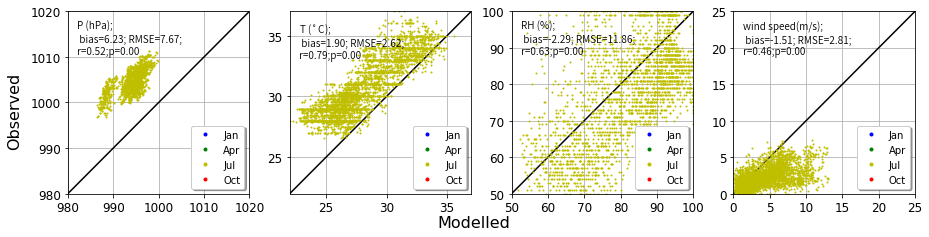

In [9]:
#scatter
from matplotlib.ticker import MultipleLocator
filename=''.join([scnm,'out_scatter'])
fig,ax=plt.subplots(1,4,figsize=(13,3))
for jj,vnm in enumerate(cnm):
    if jj>1 and jj<6:
        axi=ax[jj-2]
        yy,ymin,ymax,txx,txy,vnm0,inc=get_model(cnm[jj])
        ys1i=np.concatenate(ys1[jj-2])
        ys2i=np.concatenate(ys2[jj-2])        
        ts2i=np.concatenate(ts2[jj-2])
        vi=np.invert(np.isnan(ys2i))&np.invert(np.isnan(ys1i))
        mn=np.array(list(map(lambda x:x.month,ts2i)))
        dd=np.array(list(map(lambda x:x.day,ts2i)))
        rii,pii=pearsonr(ys2i[vi],ys1i[vi])
        ers=ys1i-ys2i        
        bias1=np.nanmean(ers)
        rmse1=np.nanmean(ers**2)**0.5
        axi.text(0.05,0.95,'%s;\n bias=%.2f; RMSE=%.2f;\nr=%.2f;p=%.2f' % (vnm0,bias1,rmse1,rii,pii),verticalalignment='top', horizontalalignment='left',\
                    transform=axi.transAxes,fontproperties=fontp) 
        xmin=ymin;xmax=ymax
        axi.axis([xmin,xmax,ymin,ymax])
        axi.plot([xmin,xmax],[ymin,ymax],color='k')
        majorLocatorx=MultipleLocator(inc)        
        for s,k,c in zip([1,4,7,10],['Jan','Apr','Jul','Oct'],['b','g','y','r']):
            sind=(dd>=10)&(dd<=15)&(mn==s)
            axi.plot(ys2i[sind],ys1i[sind],'o',color=c,mec='none',markersize=2,label=''.join([str(k)]))        
        axi.xaxis.set_major_locator(majorLocatorx)
        axi.yaxis.set_major_locator(majorLocatorx)
        axi.tick_params(axis='both', which='major', labelsize=12)
        legend=axi.legend(loc='lower right', shadow=True,markerscale=2)
        axi.grid()
fig.text(0.5, -0.02,'Modelled', ha='center', va='center',size=16)
fig.text(0.01, 0.5,'Observed', ha='center', va='center',size=16,rotation=90)
plt.tight_layout(pad=0,w_pad=0.3,rect=[0.027, 0.02, 0.98, 0.98])  
fig.savefig(''.join([filename,'_all_cwb.',fout]),rasterized=True,format=fout, \
             bbox_inches='tight',pad_inches=0.1,dpi=600)   

In [113]:
tnm=list(map(lambda x: np.nanmean(np.array(x).ravel()),(bias,rmse,r,p)))
print('filename %s\nmean bias=%.2f; RMSE=%.2f; r=%.2f; p=%.2f(%d/%dvariables<0.05)' % (filename,*tnm,sum((np.array(p)<0.05).ravel()),sum(np.invert(np.isnan(np.array(p))).ravel())))

filename /archives/simon/wrf/yulin3wda0/WRFV3/2014-04-13_18:00:00/wrfout_d03_2014-04-13_20:00:00
mean bias=1.87; RMSE=3.98; r=0.86; p=0.00(17/17variables<0.05)


/home/notebook/.conda/envs/notebook/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [114]:
hide=hidecode()
hide